In [191]:
import numpy as np
import copy
import pickle

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from scipy import signal
from scipy.fft import fft, ifft, fftfreq
from math import *

plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [192]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = np.load(f"{file_location}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f.split(".")[0]]))

In [311]:
def remove_noise_fft(x):
    x_ = copy.copy(x)
    mean = np.mean(x)
    x_ -= mean
    fourier = fft(x_)
    xf = fftfreq(x_.shape[0], wavenumbers[1]-wavenumbers[0])
    space = range(x_.shape[0])
    index = np.argsort(xf)
    fourier_real = np.real(fourier)
    fourier_imag = np.imag(fourier)
    fourier_imag = fourier_imag[index]
    fourier_real = fourier_real[index]
    
    cut_off = 575
    left, right = cut_off, x_.shape[0]-cut_off
    smooth_fourier_imag = copy.copy(fourier_imag)
    smooth_fourier_real = copy.copy(fourier_real)

    func = interpolate.UnivariateSpline(space, fourier_real, k=4, s=5e9)
    smooth_fourier_real[:left] = func(space[:left])
    smooth_fourier_real[right:] = func(space[right:])
    
    func = interpolate.UnivariateSpline(space, fourier_imag, k=4, s=1e9)
    smooth_fourier_imag[:left] = func(space[:left])
    smooth_fourier_imag[right:] = func(space[right:])
    
    smooth_fourier = smooth_fourier_real[index] + 1j * smooth_fourier_imag[index]
    
    return ifft(smooth_fourier) + mean

def split_signal(x):
    x = img[0].reshape(-1, img[0].shape[-1])
    n = np.random.randint(x.shape[0])
    n = 85
            
    x_ = copy.copy(x[n])
    x_ -= np.mean(x_)
    fourier = fft(x_)
    xf = fftfreq(x_.shape[0], wavenumbers[1]-wavenumbers[0])
    space = range(x_.shape[0])
    index = np.argsort(xf)
    fourier_real = np.real(fourier)
    fourier_imag = np.imag(fourier)
    fourier_imag = fourier_imag[index]
    fourier_real = fourier_real[index]
    
    cut_off = 575
    left, right = cut_off, x_.shape[0]-cut_off
    smooth_fourier_imag = copy.copy(fourier_imag)
    smooth_fourier_real = copy.copy(fourier_real)

    func = interpolate.UnivariateSpline(space, fourier_real, k=4, s=5e9)
    smooth_fourier_real[:left] = func(space[:left])
    smooth_fourier_real[right:] = func(space[right:])
    
    func = interpolate.UnivariateSpline(space, fourier_imag, k=4, s=1e9)
    smooth_fourier_imag[:left] = func(space[:left])
    smooth_fourier_imag[right:] = func(space[right:])

#     func = interpolate.UnivariateSpline(space, fourier_real, k=4, s=5e11)
#     smooth_fourier_real[:left] = func(space[:left])
#     smooth_fourier_real[right:] = func(space[right:])
    
#     func = interpolate.UnivariateSpline(space, fourier_imag, k=4, s=1e11)
#     smooth_fourier_imag[:left] = func(space[:left])
#     smooth_fourier_imag[right:] = func(space[right:])
    
    smooth_fourier = smooth_fourier_real[index] + 1j * smooth_fourier_imag[index]
    
    plt.plot(fourier_real, label="org real fourier")
    plt.plot(smooth_fourier_real, label="smooth real fourier")
    plt.yscale('log')
    plt.legend()
    plt.show()

    plt.plot(fourier_imag, label="org imag fourier")
    plt.plot(smooth_fourier_imag, label="smooth imag fourier")
    plt.legend()
    plt.show()
    
    
#     smooth_fourier_left = copy.copy(smooth_fourier)
#     smooth_fourier_middle = copy.copy(smooth_fourier)
#     smooth_fourier_right = copy.copy(smooth_fourier)
#     smooth_fourier_left[left:] = 0
#     smooth_fourier_middle[right:] = 0
#     smooth_fourier_middle[:left] = 0
# #     smooth_fourier_middle[left:right] = 0
#     smooth_fourier_right[:right] = 0

    plt.plot(x_, label='raw')
    plt.plot(ifft(smooth_fourier), label='smooth fourier')
    plt.legend()
    plt.show()


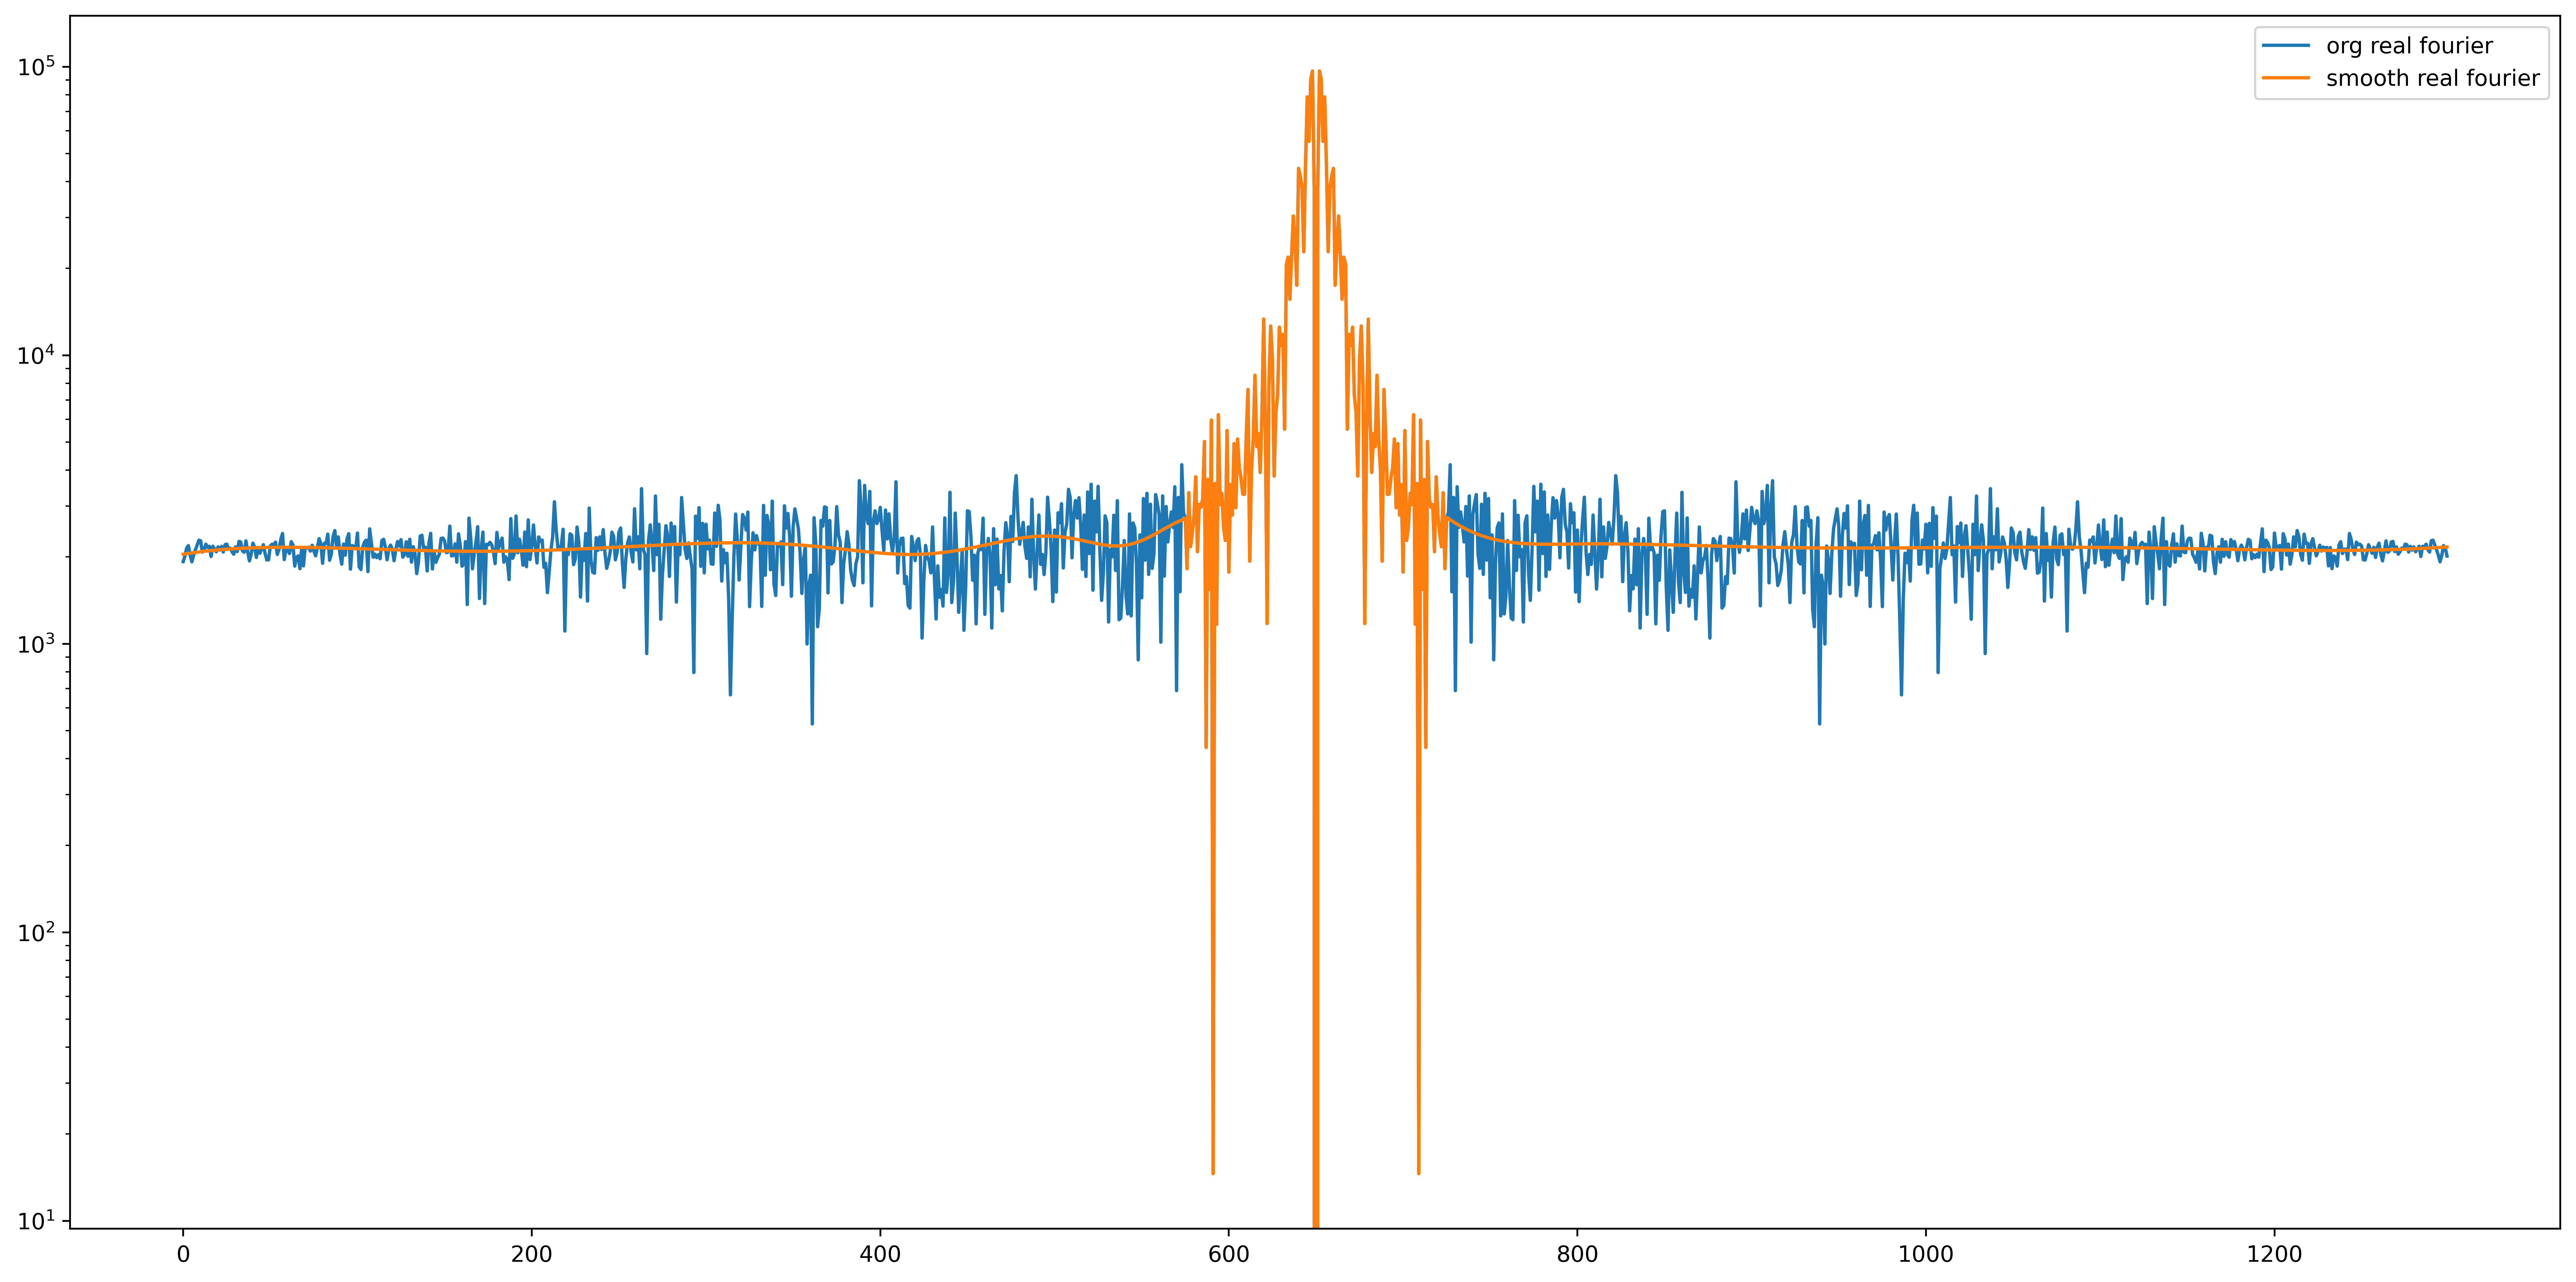

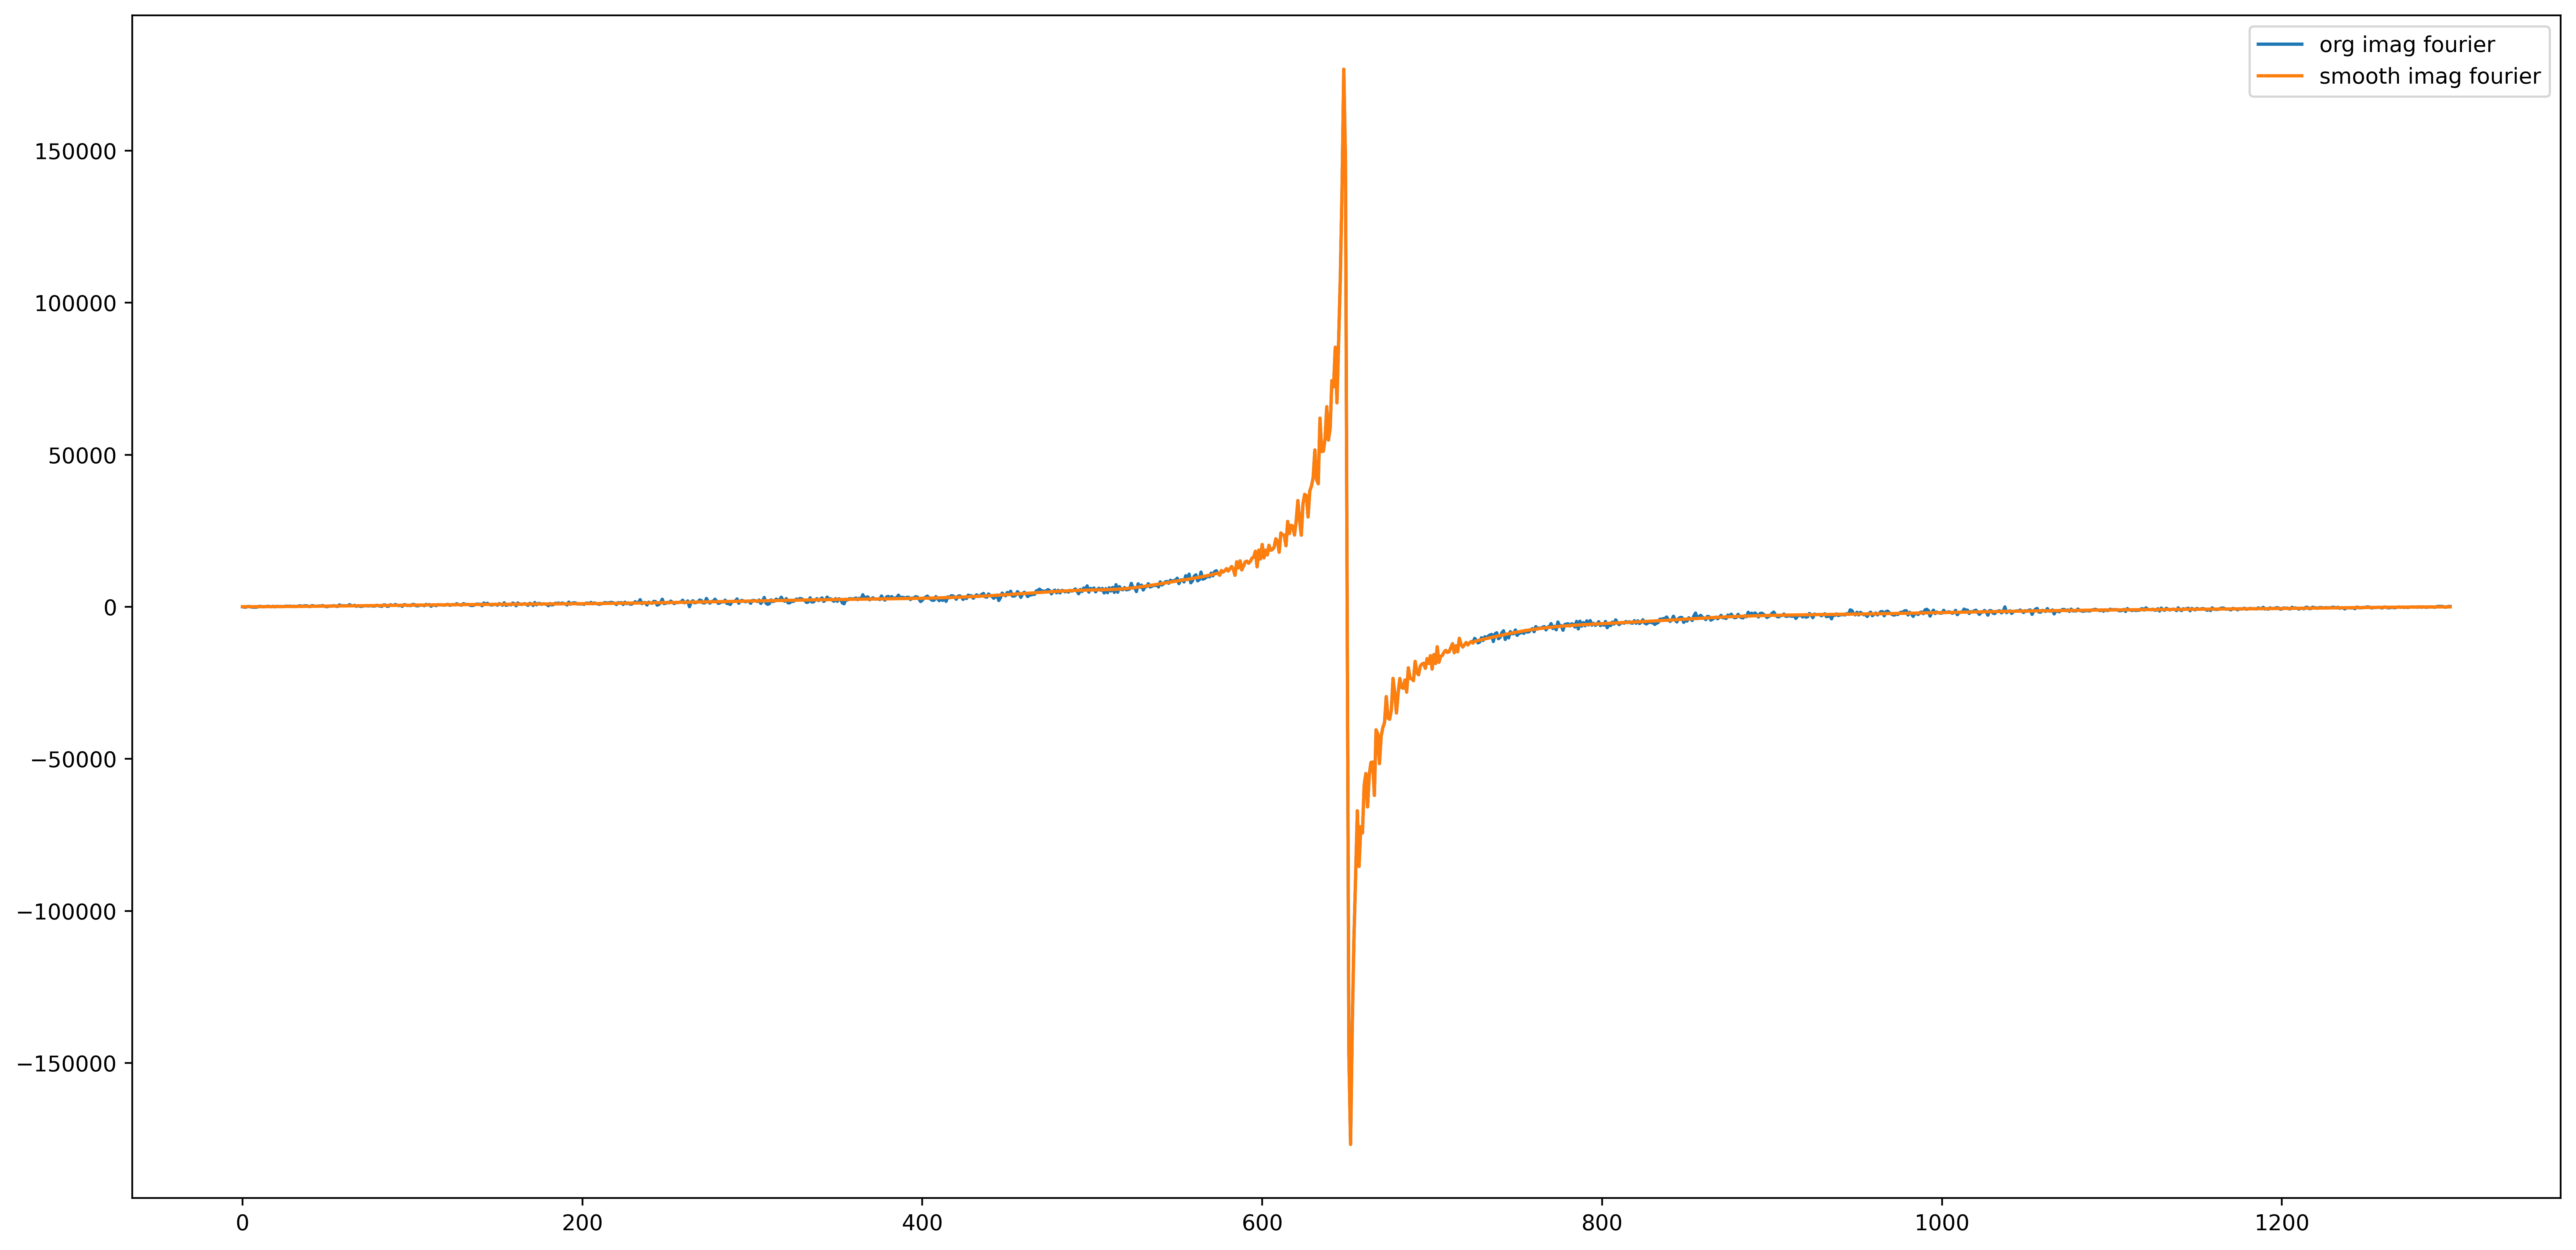

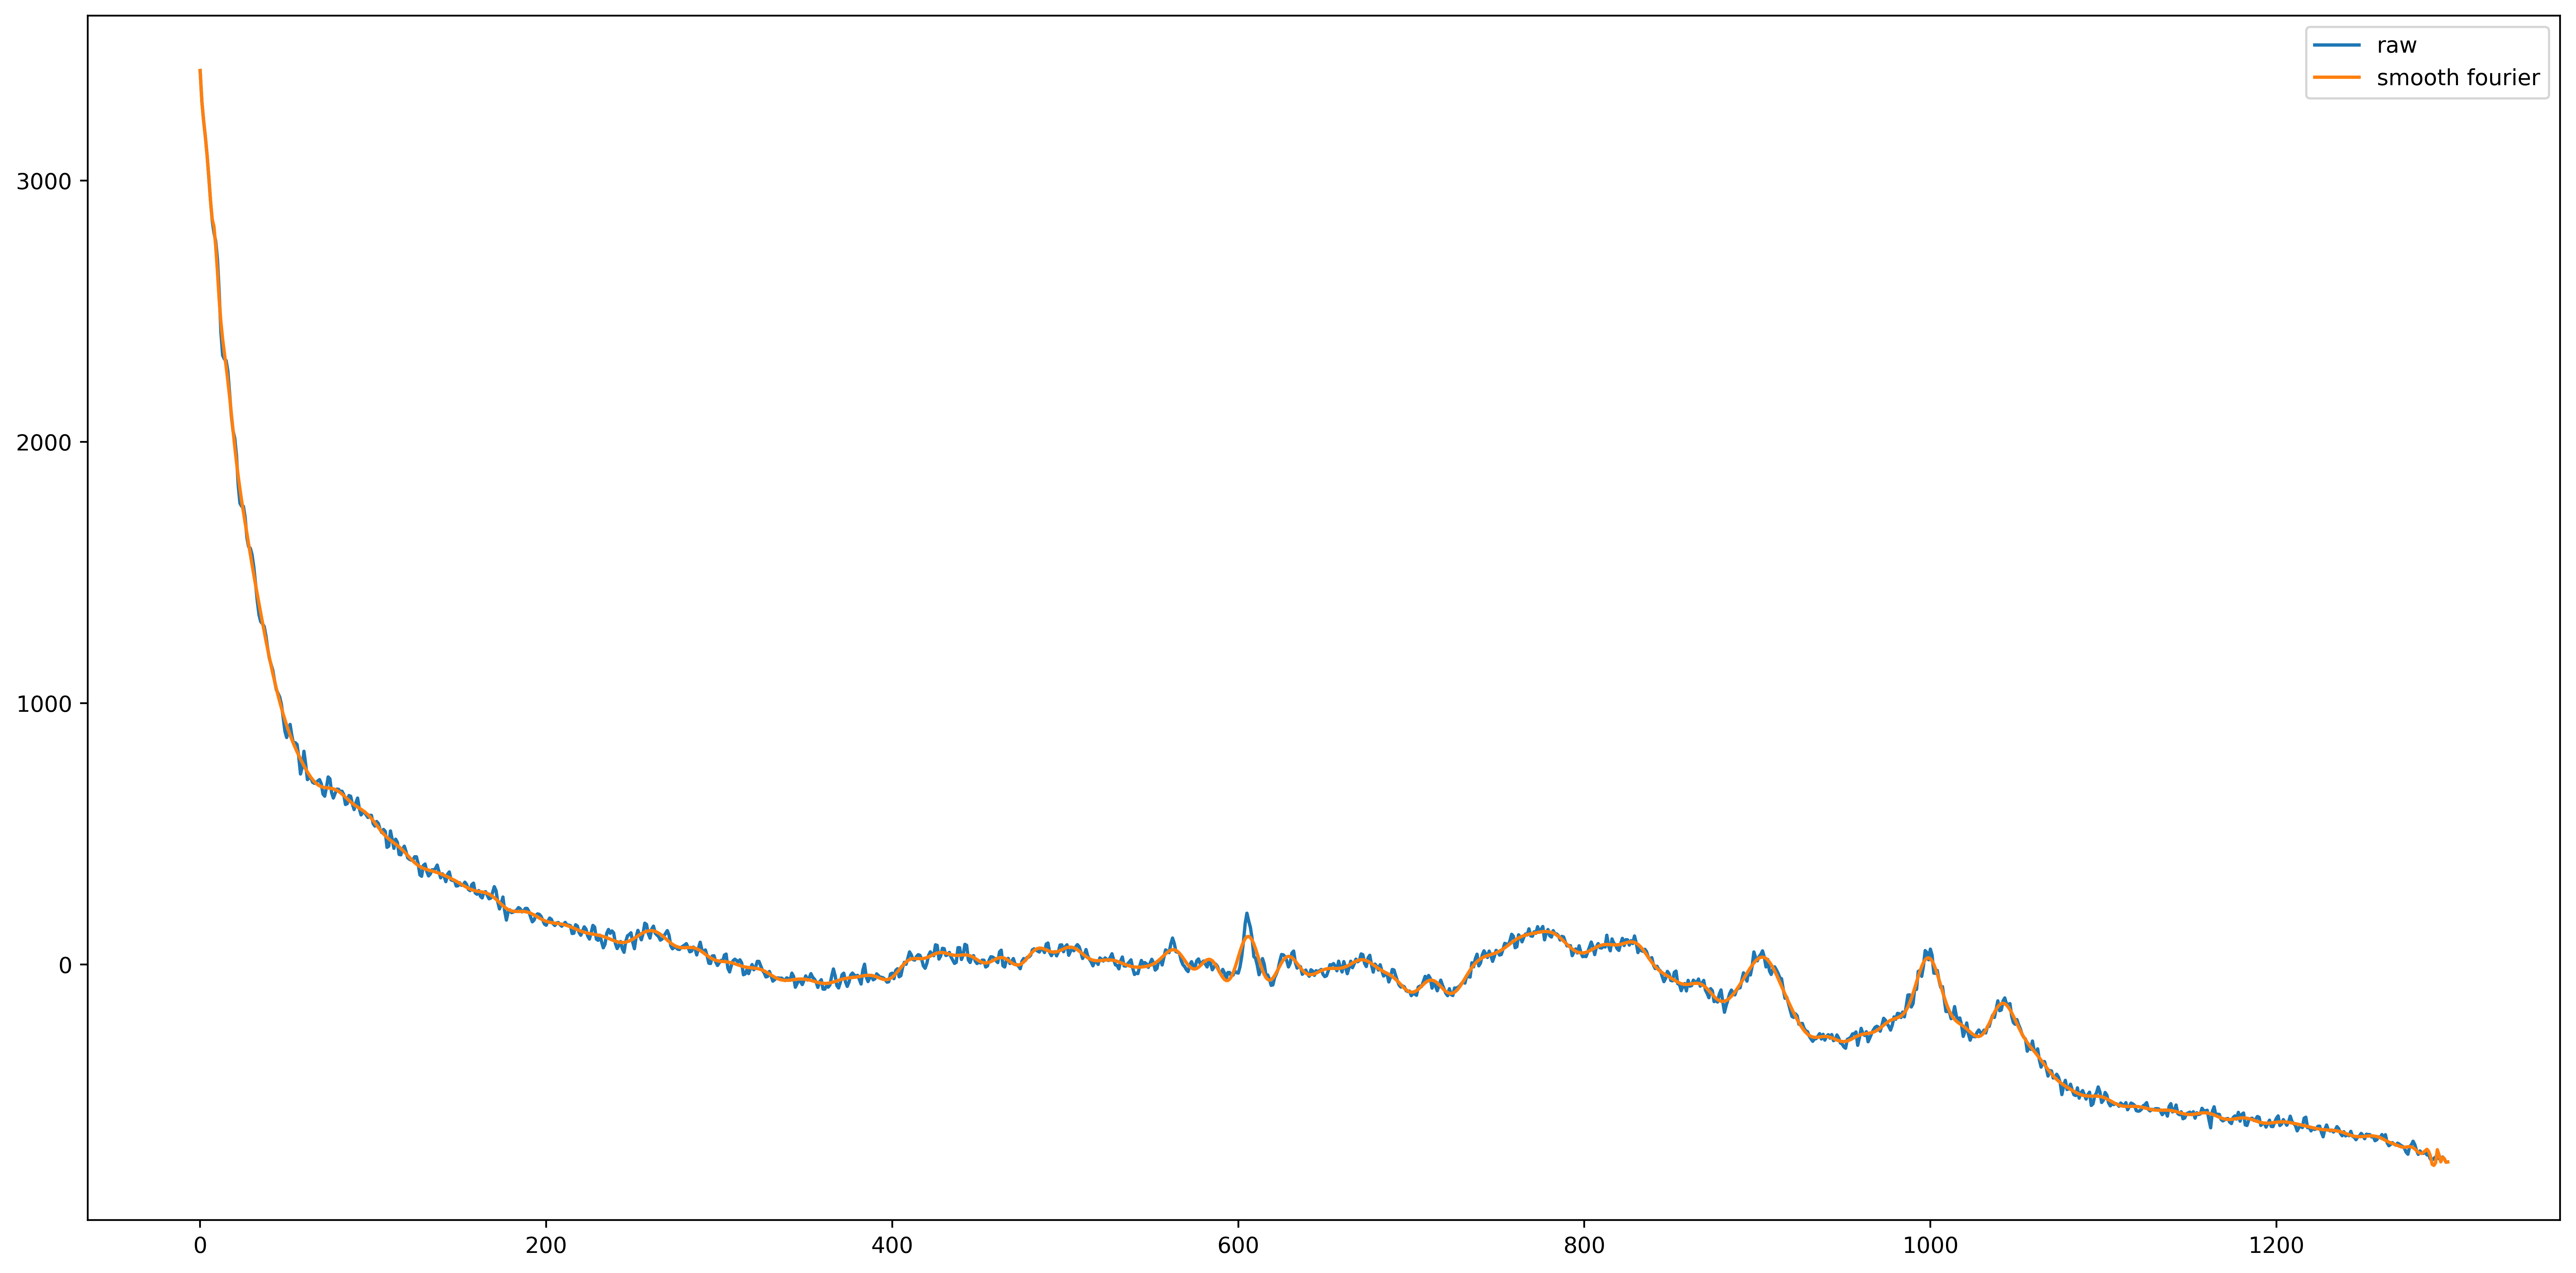

ValueError: x and y must have same first dimension, but have shapes (1300,) and (0,)

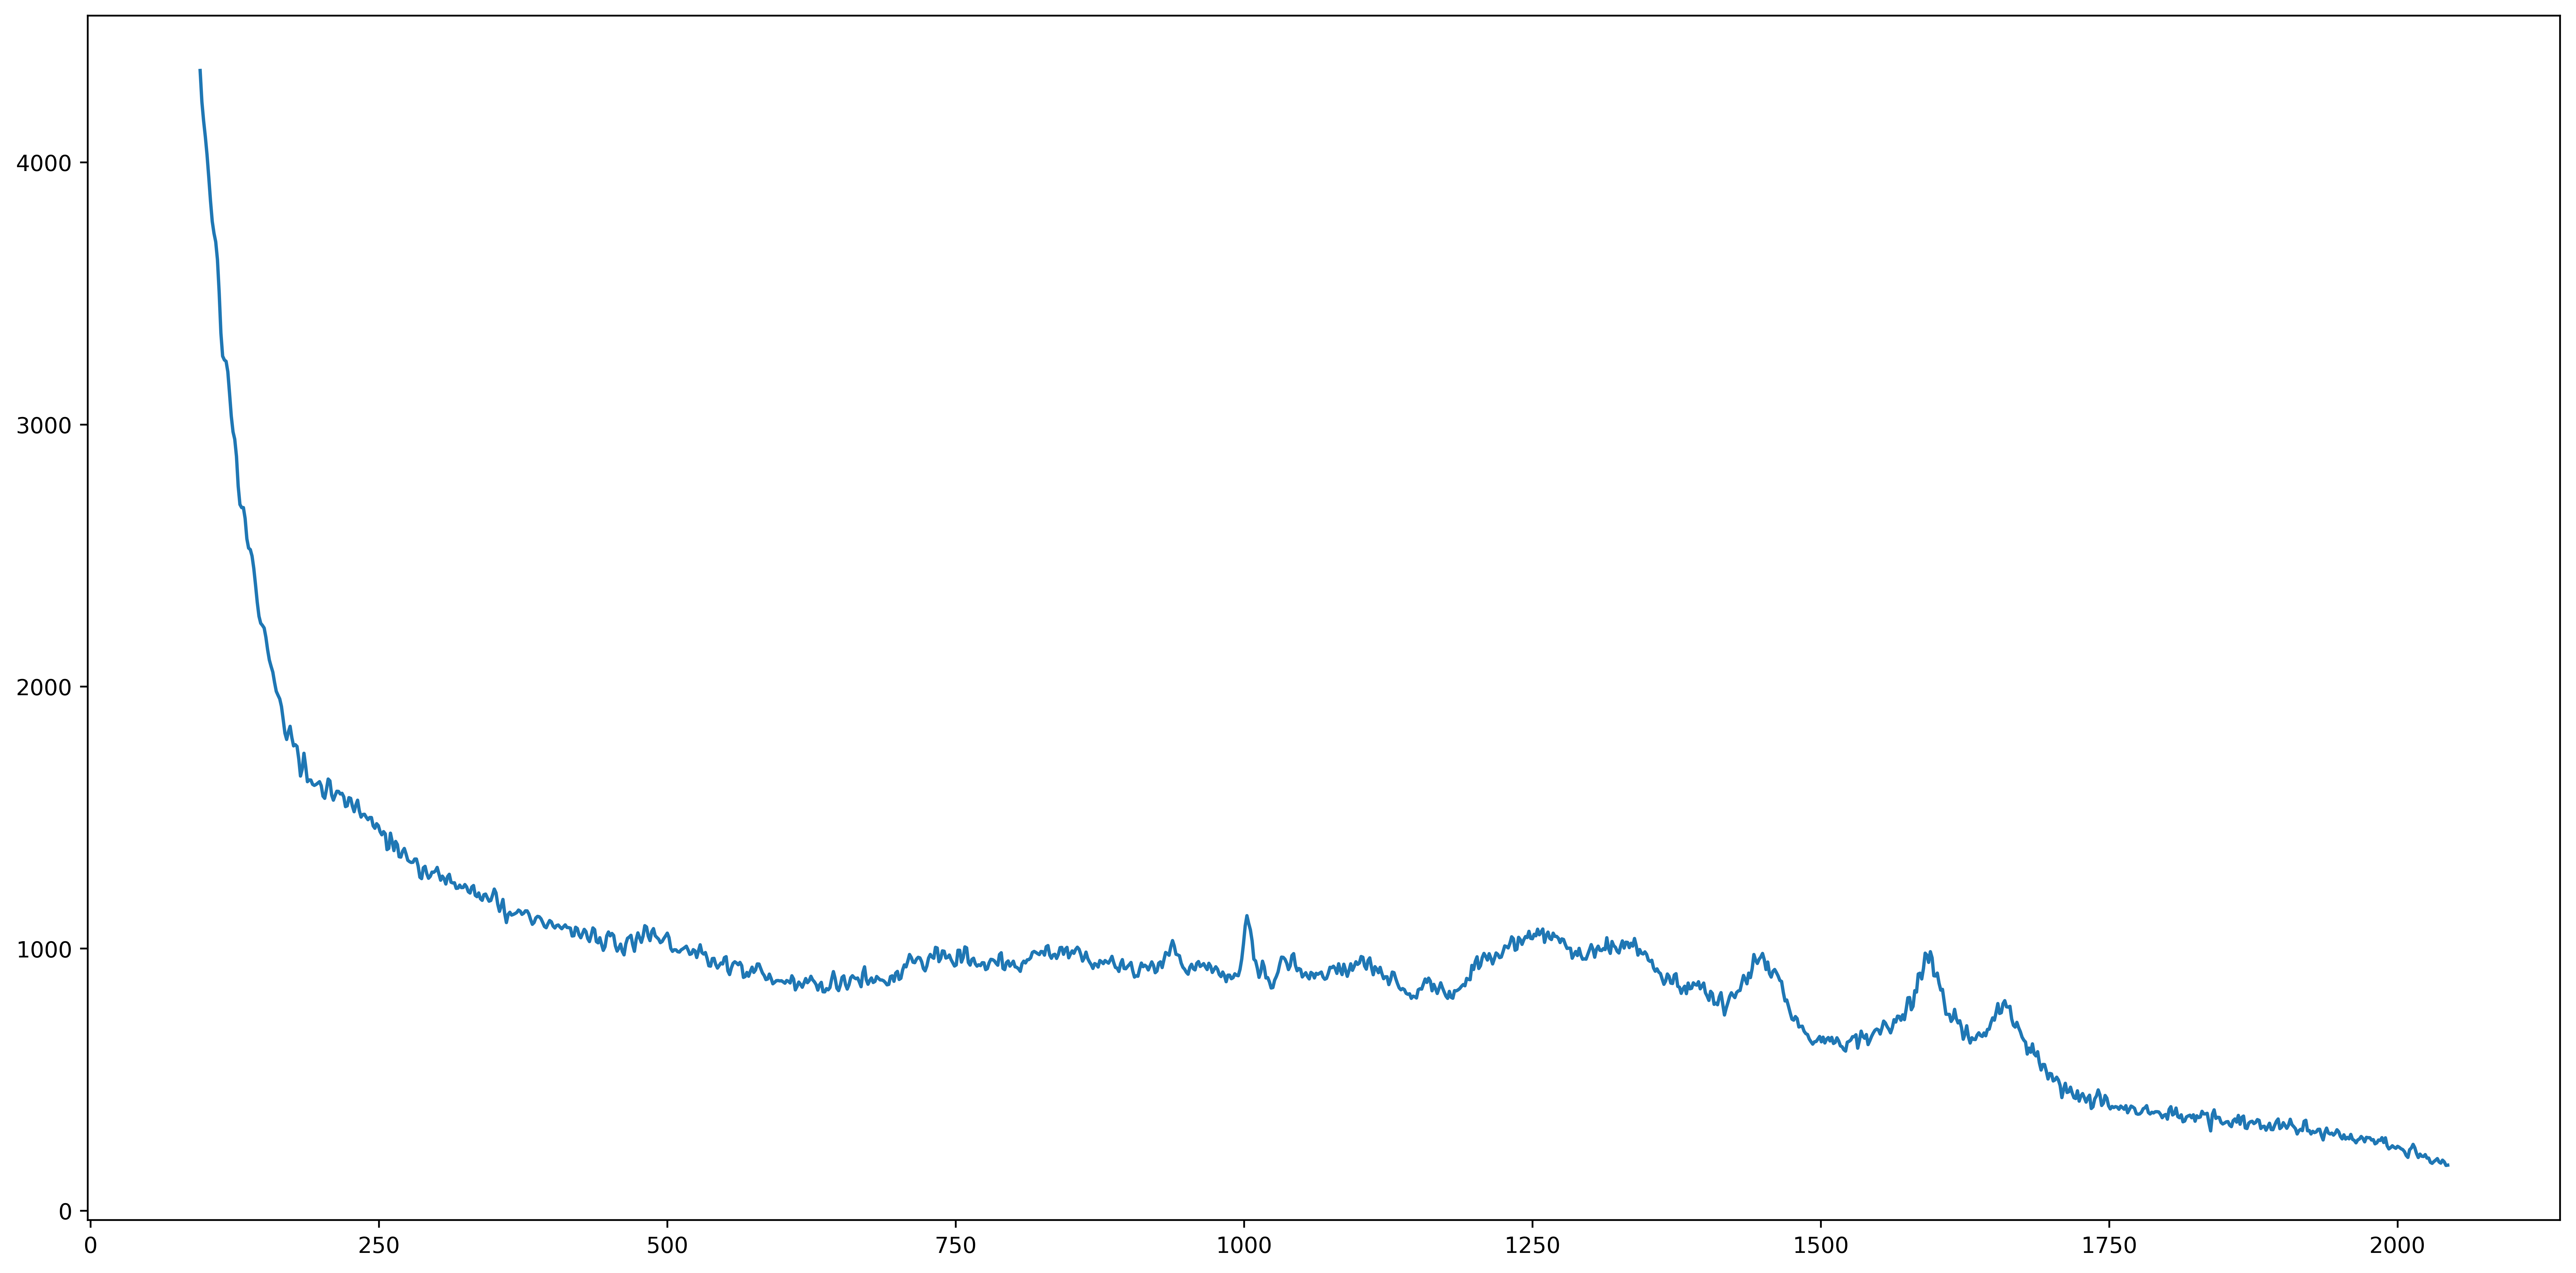

In [312]:
import timeit
from os import path
e
file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated/"
os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue

#     if j < 7:
#         continue
    
    raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  

    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
    print(f"image: {f} is done.")